In [6]:
%matplotlib inline
from itertools import chain
import logging
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import datetime
from scipy.interpolate import interp2d
from scipy.integrate import odeint
import matplotlib.dates as mdates
import seaborn as sb
from pyomo.environ import *
import pandas as pd
import pyomo.environ as pyo
from pyomo.util.infeasible import log_infeasible_constraints
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import json
import requests
import io
import pickle
import holidays
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## 2. Parameters

In [7]:
# Selecting the simulation month (this should match the from and to dates)
month = "march"

In [8]:
# Weight factor for the penalty function
weight = 3

In [9]:
fromDate = "2022-03-21 06:00:00"
toDate = "2022-03-21 18:00:00"

In [10]:
# The amount of PV upscaling
pv_upscale = 1

## 3. Data preperations

### Insitereports data loader

In [11]:
# Credentials Kropman
creds = json.load(open("creds.txt"))
serverpath = r'https://portal.insitereports.nl/data.php?'
r = requests.post(serverpath+'action=login', data=creds)
get_token = r.json()

In [12]:
def request_data_insitereports(creds:dict, report_id:int, from_date:str, to_date:str) -> pd.DataFrame:
    if(get_token['success'] == True):
        token = get_token['token']
        report = requests.get(serverpath + 'action=getdata&token=' + str(token) + '&report='+ str(report_id) + '&from=' + 
                              str(from_date) + '&to=' + str(to_date) + '&output=csv')
        textfile = report.text
        textfile = io.StringIO(textfile)
        data = pd.read_csv(textfile, sep=';', parse_dates=True, index_col='Tijdpunten [jaar-maand-dag uur:min:sec]')
        return data
    else:
        print(get_token['error'])

### 3.1. Building load and PV data
Load building data from Insitereprots.

In [13]:
df_pv = request_data_insitereports(creds, 35556, "2022-03-10", "2022-12-31")
df_loads = request_data_insitereports(creds, 35555, "2022-03-10", "2022-12-31")
df_loadEV = request_data_insitereports(creds, 35557, "2022-03-10", "2022-12-31")

In this step the actual building load is calculated using the following formula:
\begin{align*}
\ P_{Building}= P_{Power} - P_{EV} - P_{BESS} + P_{PV} + P_{Light} \\
\end{align*}

In [14]:
# Calculating the actual load
df_load = pd.DataFrame()
df_load['Load'] = df_loads.iloc[:,[3,4]].sum(axis=1) -  df_pv.iloc[:, 0] - df_loadEV.iloc[:,[0,1]].sum(axis=1)/1000 - df_loads.iloc[:,5]
df_load['PV'] = df_pv.iloc[:,0] * pv_upscale

# Interpolating missing data
df_load = df_load.interpolate(method="pad").copy()

# Resampling the data to 5 minutes
df_load.index.names = ['Datetime']
df_load = pd.concat([df_load['Load'].resample('5Min').sum()/5, df_load['PV'].resample('5Min').sum()/5], axis=1).copy()

# Selecting the data based on the from and to dates
mask = (df_load.index > fromDate) & (df_load.index <= toDate)
df_load = df_load.reset_index()

# Converting the index from datetime to integers to allow pyomo to process it
df_load['Datetime'] = df_load['Datetime'].apply(lambda x: x.value).copy()
df_load = df_load.set_index('Datetime')

df_load = df_load.loc[mask]
df_load

,Load,PV
Datetime,,
1647842700000000000,3.4692,0.0064
1647843000000000000,7.3366,0.0052
1647843300000000000,9.9384,0.0054
1647843600000000000,8.6190,0.0056
1647843900000000000,7.0214,0.0050
...,...,...
1647884400000000000,6.8612,-1.3462
1647884700000000000,7.0316,-1.0256
1647885000000000000,6.9392,-0.9128


In [15]:
# These dataframes with historic data are created using the to and from dates and are used later for comparison
df_loads['Aggregated'] = df_loads.iloc[:,[3,4]].sum(axis=1) -  df_pv.iloc[:, 0] - df_loadEV.iloc[:,[0,1]].sum(axis=1)/1000 - df_loads.iloc[:,5]
df_loadEV['Aggregated'] = df_loadEV.iloc[:, [0,1]].sum(axis=1)/1000

df_loads_5 = (df_loads.resample('5Min').sum()/5).copy()
df_loadEV_5 = (df_loadEV.resample('5Min').sum()/5).copy()
df_pv_5 = (df_pv.resample('5Min').sum()/5).copy()

#for 1 min resolution
mask = (df_loads.index > fromDate) & (df_loads.index <= toDate)
mask2 = (df_loadEV.index > fromDate) & (df_loadEV.index <= toDate)
mask3 = (df_pv.index > fromDate) & (df_pv.index <= toDate )
df_loadspartially = df_loads.loc[mask].copy()
df_loadEVpartially = df_loadEV.loc[mask2].copy()
df_pvpartially = df_pv.loc[mask3].copy() 

#for 5 mins resolution
mask = (df_loads_5.index > fromDate) & (df_loads_5.index <= toDate)
mask2 = (df_loadEV_5.index > fromDate) & (df_loadEV_5.index <= toDate)
mask3 = (df_pv_5.index > fromDate) & (df_pv_5.index <= toDate )
df_loadspartially = df_loads_5.loc[mask].copy()
df_loadEVpartially = df_loadEV_5.loc[mask2].copy()
df_pvpartially = df_pv_5.loc[mask3].copy() * pv_upscale

### 3.2. EV data

Loading the EV data from a CSV file

In [16]:
# Loading the EV data from the correct CSV file based on the entered month
df = pd.read_csv(r"ev_" + month + ".csv",index_col=(0), header=(0), parse_dates=[2,3], dtype={0: np.int64})
df['E_arrival'] = 0
mask = (df['T_arrival'] > fromDate) & (df['T_arrival'] <= toDate)
df = df.loc[mask]
df

,E_requested,T_arrival,T_departure,E_arrival
2,36.00,2022-03-21 07:45:00,2022-03-21 14:15:00,0
3,39.03,2022-03-21 08:30:00,2022-03-21 16:45:00,0
0,46.74,2022-03-21 07:45:00,2022-03-21 14:30:00,0


Preprocessing the data.

In [17]:
#seeing if df_ev already exists otherwise create a copy of the originally loaded df (charger data)
try: df_ev
except NameError: df_ev = None

if df_ev is None:
    df_ev = df.copy()

#writing new charger data to existing dataframe and keeping the rows with the most recent arrival time.
#df_ev = pd.concat([df_ev, df])
df_ev = df.copy()
df_ev = df_ev.sort_values(by=['T_arrival'],ascending=[False]).copy()
#df_ev = df_ev.reset_index().drop_duplicates(subset='ChargerId').set_index('ChargerId').sort_index().copy()

#converting the datetime object to an integer which can be processed by Pyomo
df_ev['I_arrival'] = df_ev['T_arrival'].apply(lambda x: x.value).copy()
df_ev['I_departure'] = df_ev['T_departure'].apply(lambda x: x.value).copy()

#Checking to see whether or not the arrival time is within the loads dataframe
df_ev = df_ev[df_ev.index.isin(df_ev['I_arrival'].loc[df_ev['I_arrival'].isin(df_load.index)].index)]

df_ev = df_ev.sort_values(by=['T_arrival'],ascending=[True]).copy()
df_ev = df_ev.reset_index()
df_ev

,index,E_requested,T_arrival,T_departure,E_arrival,I_arrival,I_departure
0,2,36.00,2022-03-21 07:45:00,2022-03-21 14:15:00,0,1647848700000000000,1647872100000000000
1,0,46.74,2022-03-21 07:45:00,2022-03-21 14:30:00,0,1647848700000000000,1647873000000000000
2,3,39.03,2022-03-21 08:30:00,2022-03-21 16:45:00,0,1647851400000000000,1647881100000000000


In [18]:
# Checking to see if requested energy is feasibile otherwise replacing it
df_ev['E_requested'] = df_ev['E_requested'] * 0.9
mask = df_ev['E_requested'] > (df_ev['I_departure'] - df_ev['I_arrival'])* 7.36e-11/36 * 0.9
df_ev.loc[mask,'E_requested'] = (df_ev['I_departure'] - df_ev['I_arrival'])* 7.36e-11/36 * 0.9 #max power can be delivered in the staying time
df_ev

,index,E_requested,T_arrival,T_departure,E_arrival,I_arrival,I_departure
0,2,32.400,2022-03-21 07:45:00,2022-03-21 14:15:00,0,1647848700000000000,1647872100000000000
1,0,42.066,2022-03-21 07:45:00,2022-03-21 14:30:00,0,1647848700000000000,1647873000000000000
2,3,35.127,2022-03-21 08:30:00,2022-03-21 16:45:00,0,1647851400000000000,1647881100000000000


### 3.3. Price curve
Run either Day ahead price or spot price \
(1) Day ahead price

In [19]:
# load data and to datetime
price_data = pd.read_csv("C:/Users/Rachel/OneDrive - TU Eindhoven/Kropman project/5-Code/Jupyter notebook/Day-ahead Prices_202301010000-202401010000.csv", sep=';')
price_data[['MTU (CET/CEST)','end time']] = price_data['MTU (CET/CEST)'].str.split('-',expand=True)
price_data['MTU (CET/CEST)']= pd.to_datetime(price_data['MTU (CET/CEST)'])

price_curve = pd.DataFrame()
price_curve['Datetime'] =price_data['MTU (CET/CEST)']
price_curve['Price (Euros/kWh)'] = price_data['Day-ahead Price [EUR/MWh]']
price_curve= price_curve.set_index('Datetime')

upsampled_price = price_curve.resample('5Min')
price_curve_15min = upsampled_price.interpolate(method='nearest', order=2)
#price_curve_15min['sign'] = price_curve_15min['Price']/abs(price_curve_15min['Price'])

mask = (price_curve_15min.index > "2023-03-21 06:00:00") & (price_curve_15min.index <= "2023-03-21 18:00:00")
price_curve_5min_0321 = price_curve_15min[mask]
price_curve_5min_0321.index = df_load.index
price_curve_5min_0321['sign'] = price_curve_5min_0321/abs(price_curve_5min_0321)
price_curve_5min_0321

C:\Users\Rachel\AppData\Local\Temp\ipykernel_18612\1412042751.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_curve_5min_0321['sign'] = price_curve_5min_0321/abs(price_curve_5min_0321)


,Price (Euros/kWh),sign
Datetime,,
1647842700000000000,129.79,1.0
1647843000000000000,129.79,1.0
1647843300000000000,129.79,1.0
1647843600000000000,129.79,1.0
1647843900000000000,129.79,1.0
...,...,...
1647884400000000000,132.04,1.0
1647884700000000000,132.04,1.0
1647885000000000000,132.04,1.0


(2) spot energy price curve

In [20]:
spot_data_5min = pd.read_csv("C:/Users/Rachel/OneDrive - TU Eindhoven/Kropman project/5-Code/Jupyter notebook/Energy_price__0321.csv", sep=';')
spot_data_5min[['Datetime','Price (Euros/kWh)']] = spot_data_5min[',Forecasted energy price'].str.split(',',expand=True)
spot_data_5min = spot_data_5min.drop([',Forecasted energy price'], axis=1)
spot_data_5min = spot_data_5min.set_index('Datetime')
spot_data_5min.index = df_load.index
spot_data_5min['Price (Euros/kWh)'] = spot_data_5min['Price (Euros/kWh)'].astype(float)
#spot_data_5min = spot_data_5min - spot_data_5min.mean()
spot_data_5min['sign'] = spot_data_5min/abs(spot_data_5min)
spot_data_5min

,Price (Euros/kWh),sign
Datetime,,
1647842700000000000,0.2880,1.0
1647843000000000000,0.2880,1.0
1647843300000000000,0.2880,1.0
1647843600000000000,0.2880,1.0
1647843900000000000,0.2880,1.0
...,...,...
1647884400000000000,0.3096,1.0
1647884700000000000,0.3096,1.0
1647885000000000000,0.3096,1.0


### 3.4. Forecasted data
* The input data is from ‘2022-03-14 00:00’ to ‘2022-03-14 23:59:00’ with resolution of 1 min. 
* And the result (predicted building load) will be from '2022-03-21 00:00:00' to '2022-03-21 23:55:00' with resolution of 5 mins.

In [21]:
# load the built model
filename_rf_model = '20230510_kropman_building_rf_22_23_model_0.sav'
model_rf = pickle.load(open(filename_rf_model, 'rb'))

In [22]:
# Credentials Kropman
creds = json.load(open("creds.txt"))
serverpath = r'https://portal.insitereports.nl/data.php?'
r = requests.post(serverpath+'action=login', data=creds)
get_token = r.json()

def request_data_insitereports(creds:dict, report_id:int, from_date:str, to_date:str) -> pd.DataFrame:
    if(get_token['success'] == True):
        token = get_token['token']
        report = requests.get(serverpath + 'action=getdata&token=' + str(token) + '&report='+ str(report_id) + '&from=' + 
                              str(from_date) + '&to=' + str(to_date) + '&output=csv')
        textfile = report.text
        textfile = io.StringIO(textfile)
        data = pd.read_csv(textfile, sep=';', parse_dates=True, index_col='Tijdpunten [jaar-maand-dag uur:min:sec]')
        return data
    else:
        print(get_token['error'])

In [23]:
# loading data
df_request_building = request_data_insitereports(creds, 30881, '2022-03-10', '2022-03-31')
df_request_weather = request_data_insitereports(creds, 29025, '2022-03-10', '2022-03-31')
df_predict_weather = request_data_insitereports(creds, 35941, '2022-03-10', '2022-03-31')
#!!! df_predict_pv = request_data_insitereports(creds, [code for pv forecast data], '2022-03-10', '2023-01-31')
df_predict_pv = df_load['PV']

# organizing data

df_request_building.index = pd.to_datetime(df_request_building.index, format='%Y-%m-%d %H:%M:%S')
df_request_building.columns = ['HV Kracht', 'PV', 'BESS', 'EV1', 'EV2', 'HV Licht']
df_request_building['EV1'] = df_request_building['EV1'] / 1000
df_request_building['EV2'] = df_request_building['EV2'] / 1000

df_request_weather.index = pd.to_datetime(df_request_weather.index, format='%Y-%m-%d %H:%M:%S')
df_request_weather.columns = ['TEMP', 'GHI']


# pre-processing and feature preperation functions

def data_preprocessing(df_request_building, df_request_weather):
    # Check for NaN values in datasets.
    def nan_values(df):
        nans = df.isnull().sum()
        return nans

    nans_df_request_building = nan_values(df_request_building)
    nans_df_request_weather = nan_values(df_request_weather)

    # Resample datasets to 15 min time intervals.
    def resampling(df_request_building, df_request_weather):
        df_building_resampled = df_request_building.resample('5 min', closed='left', label='left').mean()
        df_weather_resampled = df_request_weather.resample('5 min', closed='left', label='left').mean()
        return df_building_resampled, df_weather_resampled

    df_building_resampled, df_weather_resampled = resampling(df_request_building, df_request_weather)

    # Re-evaluate NaN values in datasets after resampling.
    nans_df_building_resampled = nan_values(df_building_resampled)
    nans_df_weather_resampled = nan_values(df_weather_resampled)
    
    # Fill NaN values in datasets unless there are more than sixteen executive NaN values. Then the missing gap is too 
    # large.
    def fill_nan_values(series, df):
        if np.count_nonzero(series) != 0:
            df.interpolate(method='linear', limit=16, inplace=True, )
        else:
            pass
        return df

    df_building_resampled = fill_nan_values(nans_df_building_resampled, df_building_resampled)
    df_weather_resampled = fill_nan_values(nans_df_weather_resampled, df_weather_resampled)
    
    # BESS minus of plus?
    df_building_resampled['Building load'] = (df_building_resampled['HV Kracht'] - df_building_resampled['PV'] - 
                                              df_building_resampled['BESS'] - df_building_resampled['EV1'] - 
                                              df_building_resampled['EV2'] + df_building_resampled['HV Licht'])
    
    return df_building_resampled, df_weather_resampled


def features(df_features):
    nl_holidays = []
    for date in holidays.Netherlands(years=[2022,2023]).items():
        nl_holidays.append(str(date[0]))
    X = df_features
    X['Building load previous day'] = X['Building load'].shift(288)
    X['Building load previous week'] = X['Building load'].shift(2016)
    X['Hour of day'] = X.index.hour
    X['Minute of hour'] = X.index.minute
    X['Fraction of hour'] = X['Minute of hour'] / 60
    X['Time of day'] = X['Hour of day'] + X['Fraction of hour']
    X['Day of week'] = X.index.weekday
    X['Month'] = X.index.month
    X['Dates'] = X.index.date
    X['Holiday'] = [1 if str(val) in nl_holidays else 0 for val in X['Dates']]
    X.dropna(inplace=True)
    y = X['Building load']
    X.drop(['Hour of day', 'Minute of hour', 'Fraction of hour', 'Building load', 'Dates'], axis=1, inplace=True)
    return X, y

# pre-processing data
df_building, df_weather = data_preprocessing(df_request_building, df_predict_weather)

# building load will start from 5 mins after the starting time
# whether will start from 15 mins after the starting time
df_features = pd.concat([df_building['Building load'], df_weather], axis=1)
df_features = df_features.rename(columns={"Temperatuur - Voorspelling Actueel [15min] [TE15-NEW] [°C]":"TEMP", "Globale straling - Voorspelling Actueel [15min] [GH15-NEW] [W/m²]":"GHI"})

df_features['TEMP'] = df_features['TEMP'].fillna(method='bfill')
df_features['GHI'] = df_features['GHI'].fillna(method='bfill')

# some negative load caused by reactive power are replaced by 0
df_features[df_features < 0] = 0

X, y = features(df_features)

In [24]:
# predic
building_load_predicted = model_rf.predict(X)

# put prediction result to dataframe and add the predicted pv
df_predict_load = pd.DataFrame(index=X.index)
df_predict_load['Load'] = building_load_predicted.tolist()

# Interpolating missing data
df_predict_load = df_predict_load.interpolate(method="pad").copy()

# Selecting the data based on the from and to dates
mask = (df_predict_load.index > fromDate) & (df_predict_load.index <= toDate)
df_predict_load = df_predict_load.reset_index()

df_predict_load = df_predict_load.rename(columns={"Tijdpunten [jaar-maand-dag uur:min:sec]":"Datetime"})

# Converting the index from datetime to integers to allow pyomo to process it
df_predict_load['Datetime'] = df_predict_load['Datetime'].apply(lambda x: x.value).copy()
df_predict_load = df_predict_load.set_index('Datetime')
df_predict_load = df_predict_load.loc[mask]
df_predict_load['PV'] = df_load['PV'].tolist()
df_predict_load

,Load,PV
Datetime,,
1647842700000000000,5.980782,0.0064
1647843000000000000,5.980782,0.0052
1647843300000000000,5.980782,0.0054
1647843600000000000,5.980782,0.0056
1647843900000000000,5.980782,0.0050
...,...,...
1647884400000000000,1.902782,-1.3462
1647884700000000000,1.902782,-1.0256
1647885000000000000,7.742100,-0.9128


In [25]:
df_load

,Load,PV
Datetime,,
1647842700000000000,3.4692,0.0064
1647843000000000000,7.3366,0.0052
1647843300000000000,9.9384,0.0054
1647843600000000000,8.6190,0.0056
1647843900000000000,7.0214,0.0050
...,...,...
1647884400000000000,6.8612,-1.3462
1647884700000000000,7.0316,-1.0256
1647885000000000000,6.9392,-0.9128


RMSE =  1.8576595351708962 ,MAE =  1.2994157681449687 ,NRMSE =  0.13502002668703453
building load range = ( 31.214800000000004 ,  1.6455999999999995 ) (kWh)


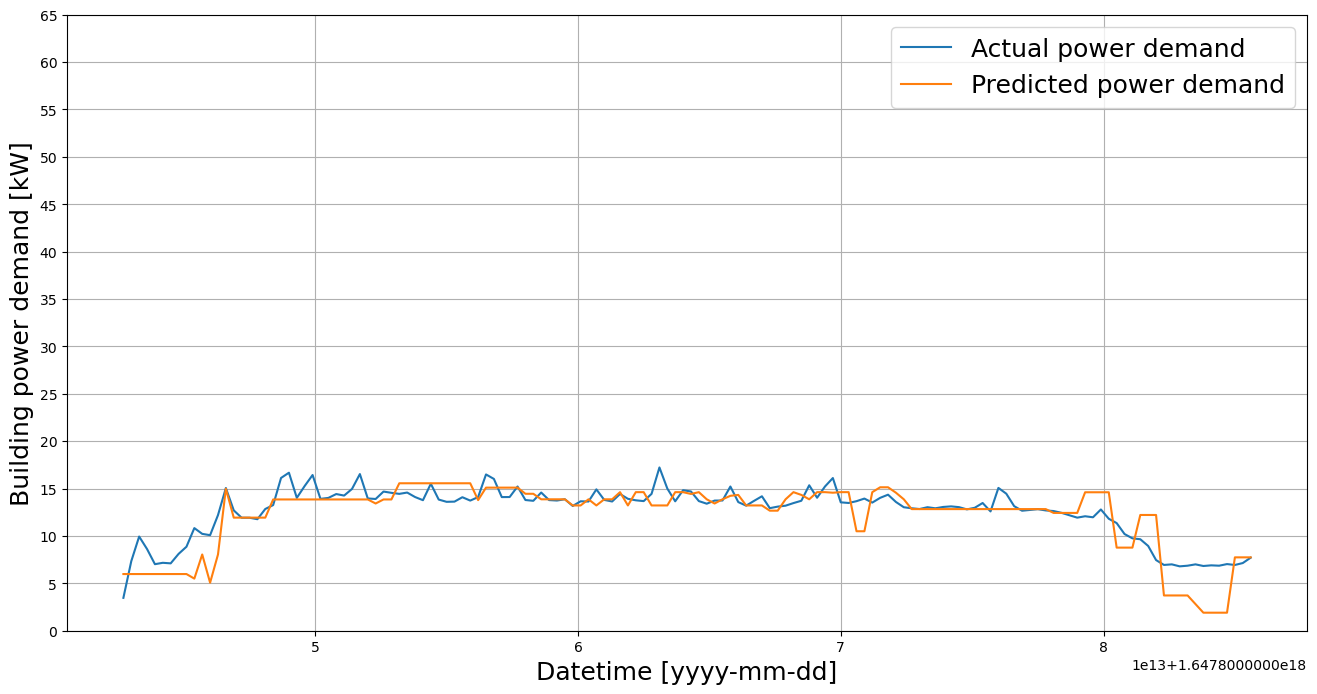

In [26]:
# visualization functions
def plot_actual_predicted(actual, predicted):
    fig, ax = plt.subplots(1, 1,figsize=(16,8))
    line1, =plt.plot(actual.index, actual, label='Actual power demand', color='C0')
    line2, =plt.plot(actual.index, predicted, label='Predicted power demand', color='C1')
    plt.xlabel('Datetime [yyyy-mm-dd]', fontsize=18)
    plt.yticks(range(0, 70, 5))
    plt.ylabel('Building power demand [kW]', fontsize=18)
    plt.legend([line1, line2], ['Actual power demand', 'Predicted power demand'], fontsize=18)
    plt.grid()
    return fig, ax
plot_actual_predicted(df_load['Load'], df_predict_load['Load'])

# evaluation of prediction model
def error_metrics(actual, predicted):  
    RMSE = (mean_squared_error(actual, predicted, squared=False))
    MAE = (mean_absolute_error(actual, predicted))
    NRMSE = (mean_squared_error(actual, predicted, squared=False)) / (actual.max()-actual.min())
    return [RMSE, MAE, NRMSE]

error_metrics_rf_test = error_metrics(df_load['Load'], df_predict_load['Load'])
print('RMSE = ', error_metrics_rf_test[0], ',MAE = ', error_metrics_rf_test[1], ',NRMSE = ', error_metrics_rf_test[2])
print('building load range = (', max(y), ', ', min(y), ') (kWh)')

## 4. Pyomo model

In [43]:
# input1_df = df_load, input2_df = df_ev
def create_model(input1_df, input2_df, input_weight, price_input):
    # Dummy variables
    # Create a dataframe with predefined values for your model to recognise
    dummies = pd.DataFrame([[0.9,6,32,7.4,230]],columns=['eff', 'imin', 'imax', 'pmax', 'vmax'],index=['Data'])
    
    # Pyomo model
    model = ConcreteModel()
    
    # Creation of Set

    #Horizon
    model.N = Set(ordered = True, initialize = RangeSet(0,len(input1_df.index)-1))

    #Chargers
    model.V = Set(ordered = True, initialize = RangeSet(0,len(input2_df.index)-1))
    
    #Single variables
    model.S = Set(ordered = True, initialize = dummies.index)
    
    # Creation Parameters
    model.Pload = Param(model.N, within = NonNegativeReals, mutable = True)
    model.Ppv = Param(model.N, within = Reals, mutable = True)
    model.T = Param(model.N, within = NonNegativeReals, mutable = True)
    model.price = Param(model.N, within = Reals, mutable = True)
    model.priceSign = Param(model.N, within = Reals, mutable = True)
    
    model.E_requested = Param(model.V, within=NonNegativeReals, mutable=True)
    model.T_arrival = Param(model.V, within=NonNegativeReals, mutable=True)
    model.T_departure = Param(model.V, within=NonNegativeReals, mutable=True)
    model.E_arrival = Param(model.V, within=NonNegativeReals, mutable=True)
    
    model.eff = Param(model.S, within = NonNegativeReals, mutable = True)
    model.imin = Param(model.S, within = NonNegativeReals, mutable = True)
    model.imax = Param(model.S, within = NonNegativeReals, mutable = True)
    model.pmax = Param(model.S, within = NonNegativeReals, mutable = True)
    model.vmax = Param(model.S, within = NonNegativeReals, mutable = True)
    
    # Update parameters
    #Single value first!!!!
    for s in model.S:
        model.eff[s] = dummies.loc[s, 'eff']
        model.imin[s] = dummies.loc[s, 'imin']
        model.imax[s] = dummies.loc[s, 'imax']
        model.pmax[s] = dummies.loc[s, 'pmax']
        model.vmax[s] = dummies.loc[s, 'vmax']
        
    # Indexed:
    for k in model.N:
        model.T[k] = input1_df.index[k]
        model.Pload[k] = input1_df['Load'].iloc[k]
        model.Ppv[k] = input1_df['PV'].iloc[k]
        model.price[k] = price_input['Price (Euros/kWh)'].iloc[k]
        model.priceSign[k] = price_input['sign'].iloc[k]
        
    for i in model.V:
        model.E_requested[i] = input2_df['E_requested'][i]
        model.T_arrival[i] = input2_df['I_arrival'][i]
        model.T_departure[i] = input2_df['I_departure'][i]
        model.E_arrival[i] = input2_df['E_arrival'][i]
        
  
    # Creation of Variables
    model.Pgrid = Var(model.N, within = Reals)
    model.Pevtot = Var(model.N, within = Reals)
    model.Pgrid_plus = Var(model.N, within = Reals)
    model.Pgrid_min = Var(model.N, within = Reals)
    model.Eff_cost = Var(model.N, within = Reals)

    model.Eff = Var(model.N, model.V, within = Reals)
    model.Icharge = Var(model.N, model.V, within = Reals)
    model.Pcharge = Var(model.N, model.V, within = Reals)
    model.Pev = Var(model.N, model.V, within = Reals)
    model.Eev = Var(model.N, model.V, within = Reals)
    model.Idiff = Var(model.N, model.V, within = Reals)
    
    # Creation of constraints
    def EV_charging(model, s, k, i):
        if pyo.value(model.T[k]) <= pyo.value(model.T_arrival[i]):
            return model.Eev[k, i] == 0
        if pyo.value(model.T[k]) == pyo.value(model.T_arrival[i]):
            return model.Eev[k, i] == model.E_arrival[i]
        if pyo.value(model.T_arrival[i]) < pyo.value(model.T[k]) < pyo.value(model.T_departure[i]):
            return model.Eev[k, i] == (model.Eev[model.N.prev(k),i] + (model.Pev[model.N.prev(k), i]*0.25/3))
        if pyo.value(model.T[k]) >= pyo.value(model.T_departure[i]):
            return model.Eev[model.N.prev(k),i] + (model.Pev[model.N.prev(k), i]*0.25/3) == model.E_requested[i]
            
           
    def Efficiency(model, s, k, i):
        return model.Pev[k,i] == model.eff[s]*model.Pcharge[k,i]
    
    def EV_aggregated(model, k):
        return model.Pevtot[k] == sum(model.Pcharge[k,i] for i in model.V)
    
    def Balance(model, s, k):
        return model.Pgrid[k] == model.Pload[k] + model.Ppv[k] + model.Pevtot[k]
        
    def charging(model, s, k, i):
        return model.Pcharge[k, i] == (model.Icharge[k, i] * model.vmax[s])/1000 
    
    def charging_max(model, s, k, i):
        return model.Pcharge[k, i] <= model.pmax[s]
    
    def current_max(model, s, k, i):
        return model.Icharge[k, i] <= model.imax[s]
    
    def current(model, k, i):
        if pyo.value(model.T[k]) < pyo.value(model.T_arrival[i]) or pyo.value(model.T[k]) >= pyo.value(model.T_departure[i]):
            return model.Icharge[k, i] == 0
        else:
            return model.Icharge[k, i] >= model.imin[s]
        
    def current_change(model, k, i):
        if k==0:
            return model.Idiff[k, i] == 0 
        else:
            return model.Idiff[k, i] == (model.Icharge[k, i] - model.Icharge[model.N.prev(k), i])**2

    
    model.con_EV_charging = Constraint(model.S, model.N, model.V, rule=EV_charging)
    model.con_Efficiency = Constraint(model.S, model.N, model.V, rule=Efficiency)
    model.con_EV_aggregated = Constraint(model.N, rule=EV_aggregated)
    model.con_Balance = Constraint(model.S, model.N, rule=Balance)
    model.con_charging = Constraint(model.S, model.N, model.V, rule=charging)
    model.con_charging_max = Constraint(model.S, model.N, model.V, rule=charging_max)
    model.con_current_max = Constraint(model.S, model.N, model.V, rule=current_max) 
    model.con_current = Constraint(model.N, model.V, rule=current)
    model.con_Idiff = Constraint(model.N, model.V, rule=current_change)


    def costfunction(model, k):
        #return sum((model.price[s]*model.Pgrid[k])**2 for k in model.N)
        #return sum((model.price[s]*model.Pgrid_plus[k])**2 for k in model.N) - sum((model.fit[s]*model.Pgrid_min[k])**2 for k in model.N)
        return sum(model.Idiff[k,i] for k in model.N for i in model.V) + sum(model.priceSign[k]*(model.price[k]*model.Pgrid[k])**2 for k in model.N) - input_weight*sum(((1/(1+model.price[k]))*model.Pcharge[k, i])**2 for k in model.N for i in model.V)    
        #return sum(model.Idiff[k,i] for k in model.N for i in model.V) + sum(model.price[k]*(model.Pgrid[k])**2 for k in model.N) - input_weight*sum(((1/(1+model.price[k]))*model.Pcharge[k, i])**2 for k in model.N for i in model.V)    
    model.obj = Objective(rule=costfunction, sense=minimize)
    
    return model

In [44]:
# Weight factor for the penalty function
weight = 40
mymodel= create_model(df_predict_load, df_ev, weight, spot_data_5min)

In [45]:
# Done! now you have to solve the model!
solver = SolverFactory('ipopt') # This is ipopt, locally installed nonlinear solver
solver.options['max_iter']= 100000 # Number of iterations
results = solver.solve(mymodel, tee=True) # tee means to show the steps of the solver

Ipopt 3.11.1: max_iter=100000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     5103
Number of nonzeros in inequality constraint Jacobian.:     1122
Number of nonzeros in Lagrangian Hessian.............:     1437

Total number of variables............................:     2445
                     variables with only lower bounds:        0
                variables with lower and upper b

  78 -2.9128343e+005 1.23e+000 1.23e+001  -1.0 4.10e+001  -1.0 6.09e-001 1.66e-001f  1
  79 -2.9128513e+005 1.21e+000 2.47e+001  -1.0 7.36e+000  -0.6 1.00e+000 1.85e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -2.9149552e+005 3.52e+000 4.01e+000  -1.0 2.15e+001  -1.1 1.00e+000 9.24e-001f  1
  81 -2.9152095e+005 1.93e+000 2.20e+000  -1.0 8.05e+000  -0.7 1.00e+000 4.72e-001f  1
  82 -2.9159068e+005 1.42e+000 1.42e+001  -1.0 2.16e+001  -1.1 1.00e+000 3.31e-001f  1
  83 -2.9159519e+005 1.31e+000 1.84e+001  -1.0 6.57e+000  -0.7 1.00e+000 7.81e-002f  1
  84 -2.9184451e+005 8.14e+000 7.81e+000  -1.0 3.92e+001  -1.2 1.00e+000 6.63e-001f  1
  85 -2.9184679e+005 7.99e+000 1.99e+001  -1.0 1.11e+001  -0.8 8.73e-001 1.91e-002f  1
  86 -2.9187251e+005 7.65e+000 1.89e+001  -1.0 9.80e+001  -1.2 5.29e-002 4.24e-002f  1
  87 -2.9187406e+005 7.62e+000 2.25e+001  -1.0 6.01e+001  -1.7 2.40e-001 4.10e-003f  1
  88 -2.9187499e+005 7.54e+000 4.03e+001  -1.0 1.

In [46]:
for s in mymodel.S:
    pv = [mymodel.Ppv[k]() for k in mymodel.N]
    load = [mymodel.Pload[k]() for k in mymodel.N]
    Pevtot = [mymodel.Pevtot[k]() for k in mymodel.N]
    grid_new = df_load['Load'].to_list() + pv + Pevtot
    grid = [mymodel.Pgrid[k]() for k in mymodel.N]
    price = [mymodel.price[k]() for k in mymodel.N]


In [47]:
for s in mymodel.S:
    pv = [mymodel.Ppv[k]() for k in mymodel.N]
    load = [mymodel.Pload[k]() for k in mymodel.N]
    Pevtot = [mymodel.Pevtot[k]() for k in mymodel.N]
    grid = df_load['Load'].to_list() + pv + Pevtot
    #grid = [mymodel.Pgrid[k]() for k in mymodel.N]
    price = [mymodel.price[k]() for k in mymodel.N]

E_EV = []
P_EV = []
Icharge = []
Ptot = []


for i in mymodel.V:
    E_EV.append([mymodel.Eev[k,i]() for k in mymodel.N]) 
    P_EV.append([mymodel.Pev[k,i]() for k in mymodel.N]) 
    Icharge.append([mymodel.Icharge[k,i]() for k in mymodel.N])

P_EVT = [mymodel.Pevtot[k]() for k in mymodel.N] 


result_df = pd.DataFrame()
for i in mymodel.V:
    result_df['EV' + str(i+1)] = pd.DataFrame(data=E_EV[i])
    result_df['PEV' + str(i+1)] = pd.DataFrame(data=P_EV[i])
    result_df['Current' + str(i+1)] = pd.DataFrame(data=Icharge[i])

result_df['PEVTot'] = pd.DataFrame(data=P_EVT)
result_df['PV'] = pd.DataFrame(data=pv)
result_df['Load'] = pd.DataFrame(data=load)
result_df['Grid'] = pd.DataFrame(data=grid)
result_df['price'] = pd.DataFrame(data=price)

result_df.index = pd.to_datetime(df_load.index)
pd.set_option('display.max_rows', 97)
result_df.head(97)

,EV1,PEV1,Current1,EV2,PEV2,Current2,EV3,PEV3,Current3,PEVTot,PV,Load,Grid,price
Datetime,,,,,,,,,,,,,,
2022-03-21 06:05:00,0.000000,-3.699444e-40,-1.451772e-39,0.000000,-1.082477e-40,-1.875365e-40,0.000000,-9.928839e-41,1.911443e-40,-6.416449e-40,0.0064,5.980782,3.4692,0.28800
2022-03-21 06:10:00,0.000000,-3.990605e-40,-1.854849e-39,0.000000,-3.870700e-40,-1.694218e-39,0.000000,2.479558e-40,7.346840e-40,-6.656753e-40,0.0052,5.980782,7.3366,0.28800
2022-03-21 06:15:00,0.000000,-2.026913e-40,-7.875282e-40,0.000000,-3.078826e-41,-2.285925e-40,0.000000,-3.528824e-42,-2.246755e-40,-1.715071e-40,0.0054,5.980782,9.9384,0.28800
2022-03-21 06:20:00,0.000000,-1.624170e-40,-7.286094e-40,0.000000,-1.337249e-52,-6.460157e-52,0.000000,-6.167418e-41,-2.979429e-40,-1.956994e-40,0.0056,5.980782,8.6190,0.28800
2022-03-21 06:25:00,0.000000,-1.406769e-40,-5.518272e-40,0.000000,1.251331e-40,3.489654e-40,0.000000,2.143482e-40,1.003556e-39,1.290584e-40,0.0050,5.980782,7.0214,0.28800
2022-03-21 06:30:00,0.000000,9.152374e-41,1.635040e-40,0.000000,1.441437e-41,1.974058e-40,0.000000,-1.968880e-66,-1.750116e-65,8.668267e-41,0.0050,5.980782,7.1666,0.28800
2022-03-21 06:35:00,0.000000,2.815066e-41,7.269350e-40,0.000000,1.540703e-41,5.535718e-40,0.000000,-6.348681e-41,4.279844e-40,-1.139790e-40,0.0052,5.980782,7.1080,0.28800
2022-03-21 06:40:00,0.000000,8.140293e-41,5.576259e-40,0.000000,1.134466e-53,5.480375e-53,0.000000,-3.068306e-40,-1.019103e-39,-1.685879e-40,0.0056,5.980782,8.1060,0.28800
2022-03-21 06:45:00,0.000000,4.064899e-40,1.788034e-39,0.000000,1.126440e-40,8.156874e-40,0.000000,-8.325472e-41,-3.383112e-40,3.006391e-40,0.0040,5.980782,8.8626,0.28800


#Store current amount of energy in table
for i in mymodel.V:
    df_ev.iloc[i,3] = result_df['EV' + str(i+1)][47]

(0.0, 60.0)

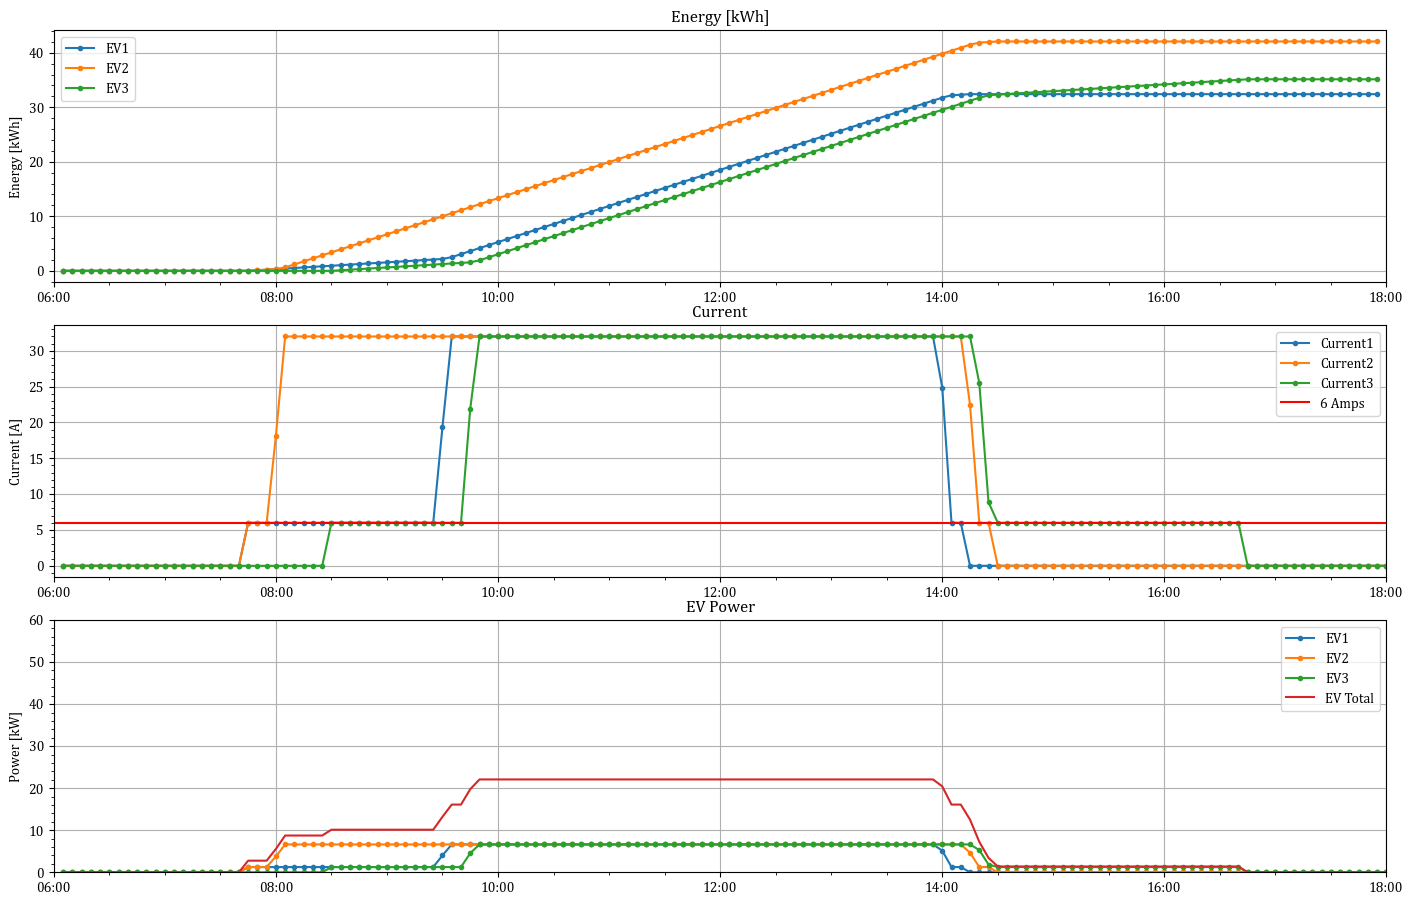

In [48]:
fig, axs = plt.subplots(3, 1, figsize=(14, 9), sharex=False)
fig.tight_layout()
axs[0].set_title('Energy [kWh]')
for i in mymodel.V:
    axs[0].plot(result_df['EV' + str(i+1)], label='EV' + str(i+1), marker=".")
axs[0].grid()
axs[0].set_ylabel('Energy [kWh]')
axs[0].legend()
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axs[0].minorticks_on()
axs[0].set_xlim(pd.Timestamp(fromDate), pd.Timestamp(toDate))

axs[1].set_title('Current')
for i in mymodel.V:
    axs[1].plot(result_df['Current' + str(i+1)], label='Current' + str(i+1), marker=".")
axs[1].grid()
axs[1].set_ylabel('Current [A]')
axs[1].axhline(y=6, color="red", label="6 Amps")
axs[1].legend()
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axs[1].minorticks_on()
axs[1].set_xlim(pd.Timestamp(fromDate), pd.Timestamp(toDate))

axs[2].set_title('EV Power')
for i in mymodel.V:
    axs[2].plot(result_df['PEV' + str(i+1)], label='EV' + str(i+1), marker=".")
axs[2].plot(result_df['PEVTot'], label="EV Total")
axs[2].grid()
axs[2].set_ylabel('Power [kW]')
axs[2].legend()
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axs[2].minorticks_on()
axs[2].set_xlim(pd.Timestamp(fromDate), pd.Timestamp(toDate))
axs[2].set_ylim([0,60])

Text(0, 0.5, 'Price [Euros/kWh]')

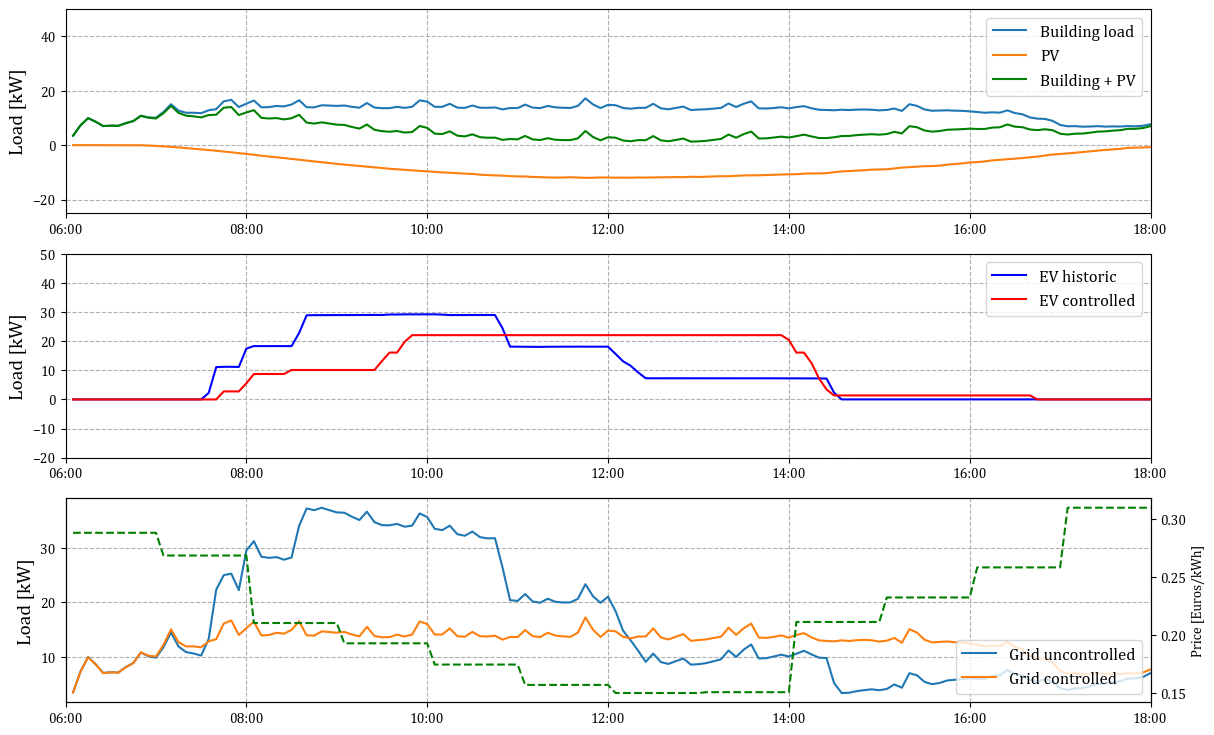

In [49]:
fig6, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(14,9))
plt.rcParams["font.family"] = "Cambria"
#fig6.patch.set_alpha(0)
#ax1.set_title("21 maart - Historische data vs Optimalisatie", loc="center", fontsize=16)
ax1.plot(df_loadspartially['Aggregated'], label='Building load')
ax1.plot(df_pvpartially.iloc[:, 0], label="PV")
ax1.plot(df_pvpartially.iloc[:, 0] + df_loadspartially['Aggregated'], label="Building + PV", color="green")
ax1.set_xlim(pd.Timestamp(fromDate), pd.Timestamp(toDate))
ax1.set_ylabel('Load [kW]', fontsize=14)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.legend(loc='upper right', fontsize=12)
ax1.set_ylim([-25, 50])
ax1.grid(linestyle='--')

ax2.plot(df_loadEVpartially['Aggregated'], label="EV historic", color="blue")
ax2.plot(result_df['PEVTot'], label="EV controlled", color="red")
ax2.set_xlim(pd.Timestamp(fromDate), pd.Timestamp(toDate))
ax2.set_ylabel('Load [kW]', fontsize=14)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.legend(loc='upper right', fontsize=12)
ax2.set_ylim([-20, 50])
ax2.grid(linestyle='--')

ax3.plot((df_pvpartially.iloc[:, 0] + df_loadspartially['Aggregated'] + df_loadEVpartially['Aggregated']), label="Grid uncontrolled")
ax3.plot(result_df['Grid'], label="Grid controlled")
ax3.set_xlim(pd.Timestamp(fromDate), pd.Timestamp(toDate))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#ax3.set_ylim([-20, 50])

ax3.set_ylabel('Load [kW]', fontsize=14)
ax3.grid(linestyle='--')
ax3.legend(loc='lower right', fontsize=12)

ax4 = ax3.twinx()
ax4.plot(result_df['price'], 'g--')
ax4.set_ylabel('Price [Euros/kWh]')


In [50]:
print(sum(P_EVT*result_df['price']/12))

20.882504082925138


# KPI evaluations

In [2]:
df_grid = pd.DataFrame()
df_grid['Load'] = df_loadspartially['Aggregated'] + df_loadEVpartially['Aggregated']
df_grid['Grid'] = df_pvpartially.iloc[:, 0] + df_loadspartially['Aggregated'] + df_loadEVpartially['Aggregated']
result_df['Grid'].max()

NameError: name 'pd' is not defined

### Power peak reduction

In [30]:
PPR = df_grid['Grid'].max() - result_df['Grid'].max()
PPR

20.1158

# Tunning weight
Fine the weight elbow

In [107]:
import time
# Weight factor for the penalty function
weight = [0, 0.25, 0.5, 0.75, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 60, 100]
TotalPrice = []
PeakPower = []

for w in weight:
    mymodel= create_model(df_load, df_ev, w, spot_data_5min)

    # Done! now you have to solve the model!
    solver = SolverFactory('ipopt') # This is ipopt, locally installed nonlinear solver
    solver.options['max_iter']= 100000 # Number of iterations
    results = solver.solve(mymodel, tee=True) # tee means to show the steps of the solver

    # organizing results
    for s in mymodel.S:
        pv = [mymodel.Ppv[k]() for k in mymodel.N]
        load = [mymodel.Pload[k]() for k in mymodel.N]
        grid = [mymodel.Pgrid[k]() for k in mymodel.N]
        grid_plus = [mymodel.Pgrid_plus[k]() for k in mymodel.N]
        grid_min = [mymodel.Pgrid_min[k]() for k in mymodel.N]
        price = [mymodel.price[k]() for k in mymodel.N]

    E_EV = []
    P_EV = []
    Icharge = []
    Ptot = []

    for i in mymodel.V:
        E_EV.append([mymodel.Eev[k,i]() for k in mymodel.N]) 
        P_EV.append([mymodel.Pev[k,i]() for k in mymodel.N]) 
        Icharge.append([mymodel.Icharge[k,i]() for k in mymodel.N])

    P_EVT = [mymodel.Pevtot[k]() for k in mymodel.N] 


    result_df = pd.DataFrame()
    for i in mymodel.V:
        result_df['EV' + str(i+1)] = pd.DataFrame(data=E_EV[i])
        result_df['PEV' + str(i+1)] = pd.DataFrame(data=P_EV[i])
        result_df['Current' + str(i+1)] = pd.DataFrame(data=Icharge[i])

    result_df['PEVTot'] = pd.DataFrame(data=P_EVT)
    result_df['PV'] = pd.DataFrame(data=pv)
    result_df['Load'] = pd.DataFrame(data=load)
    result_df['Grid'] = pd.DataFrame(data=grid)
    result_df['Grid_plus'] = pd.DataFrame(data=grid_plus)
    result_df['Grid_min'] = pd.DataFrame(data=grid_min)
    result_df['price'] = pd.DataFrame(data=price)

    result_df.index = pd.to_datetime(df_load.index)
    pd.set_option('display.max_rows', 97)

    # KPI evaluation (price and power peak)
    TotalPrice.append(sum(P_EVT*result_df['price']/12))

    df_grid = pd.DataFrame()
    df_grid['Load'] = df_loadspartially['Aggregated'] + df_loadEVpartially['Aggregated']
    df_grid['Grid'] = df_pvpartially.iloc[:, 0] + df_loadspartially['Aggregated'] + df_loadEVpartially['Aggregated']
    #PPR = df_grid['Grid'].max() - result_df['Grid'].max()
    PP = result_df['Grid'].max()
    PeakPower.append(PP)
  

Ipopt 3.11.1: max_iter=100000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     5103
Number of nonzeros in inequality constraint Jacobian.:     1122
Number of nonzeros in Lagrangian Hessian.............:     1005

Total number of variables............................:     2445
                     variables with only lower bounds:        0
                variables with lower and upper b

Ipopt 3.11.1: max_iter=100000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     5103
Number of nonzeros in inequality constraint Jacobian.:     1122
Number of nonzeros in Lagrangian Hessian.............:     1437

Total number of variables............................:     2445
                     variables with only lower bounds:        0
                variables with lower and upper b

Ipopt 3.11.1: max_iter=100000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     5103
Number of nonzeros in inequality constraint Jacobian.:     1122
Number of nonzeros in Lagrangian Hessian.............:     1437

Total number of variables............................:     2445
                     variables with only lower bounds:        0
                variables with lower and upper b

Ipopt 3.11.1: max_iter=100000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     5103
Number of nonzeros in inequality constraint Jacobian.:     1122
Number of nonzeros in Lagrangian Hessian.............:     1437

Total number of variables............................:     2445
                     variables with only lower bounds:        0
                variables with lower and upper b

  11 -1.9038054e+004 3.72e+001 6.01e+001  -1.0 2.72e+001  -0.7 1.00e+000 1.18e-001f  1
  12 -1.9297037e+004 3.66e+001 5.89e+001  -1.0 2.71e+002  -1.2 4.16e-002 1.56e-002f  1
  13 -1.9416717e+004 3.28e+001 3.74e+001  -1.0 2.36e+001  -0.7 1.00e+000 1.05e-001f  1
  14 -1.9577198e+004 1.70e+001 5.23e+001  -1.0 2.11e+001  -0.3 1.00e+000 4.98e-001f  1
  15 -1.9788669e+004 1.39e+001 4.06e+001  -1.0 1.06e+001  -0.8 1.00e+000 1.87e-001f  1
  16 -1.9906780e+004 8.69e+000 1.38e+001  -1.0 8.63e+000  -0.4 1.00e+000 3.77e-001f  1
  17 -2.0017913e+004 7.15e+000 4.15e+001  -1.0 8.92e+000  -0.8 1.00e+000 1.78e-001f  1
  18 -2.0066681e+004 4.73e+000 1.97e+001  -1.0 7.12e+000  -0.4 1.00e+000 3.40e-001f  1
  19 -2.0123111e+004 3.91e+000 2.97e+001  -1.0 6.31e+000  -0.9 1.00e+000 1.73e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -2.0179396e+004 1.57e+000 9.61e+000  -1.0 3.92e+000  -0.5 1.00e+000 5.99e-001f  1
  21 -2.0218969e+004 1.23e+000 1.44e+001  -1.0 4.

  31 -2.7617391e+004 7.88e-001 2.05e+000  -1.0 5.11e+000  -1.2 1.00e+000 5.51e-001f  1
  32 -2.7636144e+004 1.38e+000 2.46e+000  -1.0 1.04e+001  -1.7 1.00e+000 5.19e-001f  1
  33 -2.7640323e+004 1.48e+000 3.16e+000  -1.0 2.68e+001  -2.1 2.19e-001 8.53e-002f  1
  34 -2.7646609e+004 1.21e+000 1.39e+000  -1.0 6.26e+000  -1.7 1.00e+000 5.88e-001f  1
  35 -2.7655165e+004 2.30e+000 1.64e-001  -1.0 7.75e+000  -2.2 1.00e+000 1.00e+000f  1
  36 -2.7657647e+004 1.25e+000 6.67e-002  -1.0 1.05e+001    -  6.38e-001 6.54e-001h  1
  37 -2.7650661e+004 2.04e-001 5.02e-003  -1.0 2.20e+000  -2.7 1.00e+000 1.00e+000h  1
  38 -2.7661548e+004 1.69e-001 2.10e-002  -1.7 3.70e+000    -  5.34e-001 5.21e-001f  1
  39 -2.7667161e+004 1.06e-001 4.79e-001  -2.5 1.71e+000  -3.2 8.24e-001 4.55e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -2.7673279e+004 2.11e-002 2.99e-004  -2.5 1.01e+000    -  1.00e+000 1.00e+000f  1
  41 -2.7673694e+004 1.36e-003 1.50e-009  -3.8 1.

  49 -6.4168470e+004 1.36e+000 3.62e+000  -1.7 2.40e+001  -1.7 4.36e-002 2.24e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -6.4176976e+004 1.22e+000 3.29e+000  -1.7 9.25e+000  -1.2 1.00e+000 3.57e-001f  1
  51 -6.4178443e+004 1.18e+000 3.34e+000  -1.7 1.30e+001  -1.7 5.70e-001 3.72e-002f  1
  52 -6.4196137e+004 1.04e+000 1.47e+000  -1.7 6.20e+000  -1.3 4.33e-001 1.00e+000f  1
  53 -6.4224588e+004 4.40e+000 3.49e+000  -1.7 4.15e+001  -1.8 1.04e-001 3.44e-001f  1
  54 -6.4224655e+004 4.36e+000 1.56e+000  -1.7 6.95e+000  -1.3 4.12e-001 8.07e-003h  1
  55 -6.4243256e+004 4.00e+000 2.39e+000  -1.7 2.28e+001  -1.8 1.00e+000 7.27e-001f  1
  56 -6.4243711e+004 4.00e+000 6.42e+000  -1.7 5.55e+002  -2.3 3.19e-002 1.15e-003f  1
  57 -6.4247343e+004 2.21e+000 1.21e+000  -1.7 1.47e+001  -1.9 1.00e+000 7.19e-001h  1
  58 -6.4271753e+004 5.82e+000 1.12e+000  -1.7 3.51e+001  -2.3 5.81e-001 4.93e-001f  1
  59 -6.4272992e+004 5.87e+000 7.82e-001  -1.7 6.

  45 -1.0070224e+005 4.08e+000 8.44e+000  -1.0 4.30e+000  -0.6 1.00e+000 5.35e-002f  1
  46 -1.0072086e+005 3.34e+000 1.24e+001  -1.0 1.29e+001  -1.1 1.00e+000 1.82e-001f  1
  47 -1.0082922e+005 5.58e+000 1.05e+001  -1.0 4.70e+001  -1.6 4.85e-001 3.38e-001f  1
  48 -1.0083146e+005 5.41e+000 7.64e+000  -1.0 1.41e+001  -1.2 3.94e-001 3.19e-002f  1
  49 -1.0084426e+005 5.38e+000 6.82e+000  -1.0 1.31e+003  -1.7 1.79e-003 4.44e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -1.0086320e+005 2.81e+000 6.42e+000  -1.0 9.48e+000  -1.2 1.00e+000 4.78e-001f  1
  51 -1.0086697e+005 3.49e-001 5.96e-001  -1.0 3.78e+000  -0.8 1.00e+000 9.52e-001f  1
  52 -1.0088445e+005 5.67e-001 3.74e+000  -1.0 1.25e+001  -1.3 1.00e+000 3.35e-001f  1
  53 -1.0089071e+005 4.23e-001 3.15e+000  -1.0 4.18e+000  -0.9 1.00e+000 3.98e-001f  1
  54 -1.0092049e+005 1.94e+000 2.59e+000  -1.0 1.67e+001  -1.3 1.00e+000 4.76e-001f  1
  55 -1.0092505e+005 1.85e+000 3.71e+000  -1.0 4.

  21 -1.3267713e+005 1.34e+001 2.40e+002  -1.0 1.29e+001  -0.0 1.00e+000 1.15e-001f  1
  22 -1.3298342e+005 1.08e+001 1.51e+002  -1.0 9.79e+000   0.4 1.00e+000 1.97e-001f  1
  23 -1.3347542e+005 9.71e+000 2.34e+002  -1.0 1.04e+001  -0.1 1.00e+000 9.85e-002f  1
  24 -1.3393051e+005 6.43e+000 1.27e+002  -1.0 9.24e+000   0.3 1.00e+000 3.38e-001f  1
  25 -1.3434825e+005 5.85e+000 1.97e+002  -1.0 2.61e+001  -0.1 1.00e+000 9.09e-002f  1
  26 -1.3450184e+005 4.97e+000 1.23e+002  -1.0 5.65e+000   0.3 1.00e+000 1.50e-001f  1
  27 -1.3494167e+005 4.22e+000 1.56e+002  -1.0 1.45e+001  -0.2 1.00e+000 1.51e-001f  1
  28 -1.3513007e+005 3.30e+000 9.79e+001  -1.0 4.10e+000   0.2 1.00e+000 2.19e-001f  1
  29 -1.3533644e+005 2.97e+000 1.27e+002  -1.0 9.64e+000  -0.2 1.00e+000 9.88e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -1.3554111e+005 1.96e+000 6.86e+001  -1.0 3.80e+000   0.2 1.00e+000 3.39e-001f  1
  31 -1.3567536e+005 1.83e+000 1.05e+002  -1.0 1.

Ipopt 3.11.1: max_iter=100000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     5103
Number of nonzeros in inequality constraint Jacobian.:     1122
Number of nonzeros in Lagrangian Hessian.............:     1437

Total number of variables............................:     2445
                     variables with only lower bounds:        0
                variables with lower and upper b

  76 -1.7453811e+005 9.29e-001 7.41e-001  -1.0 7.23e+000  -1.0 1.00e+000 1.00e+000f  1
  77 -1.7454994e+005 9.40e-001 6.68e+000  -1.7 2.79e+001  -1.5 6.59e-001 7.46e-002f  1
  78 -1.7455428e+005 8.79e-001 6.42e+000  -1.7 8.57e+000  -1.0 1.00e+000 7.00e-002f  1
  79 -1.7459802e+005 1.70e+000 5.01e+000  -1.7 3.29e+001  -1.5 2.28e-001 2.14e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -1.7459904e+005 1.67e+000 1.36e+001  -1.7 7.30e+000  -1.1 1.00e+000 2.18e-002f  1
  81 -1.7462453e+005 1.32e+000 1.61e+001  -1.7 2.58e+001  -1.6 1.00e+000 2.10e-001f  1
  82 -1.7465226e+005 1.13e+000 4.48e+000  -1.7 8.64e+000  -1.1 1.00e+000 6.94e-001f  1
  83 -1.7467156e+005 1.54e+000 5.25e+000  -1.7 3.86e+001  -1.6 4.47e-001 1.46e-001f  1
  84 -1.7467243e+005 1.53e+000 1.18e+001  -1.7 4.75e+001  -2.1 6.53e-001 8.35e-003f  1
  85 -1.7471573e+005 1.44e+000 1.13e+000  -1.7 1.77e+001  -1.7 1.00e+000 9.54e-001f  1
  86 -1.7471772e+005 1.42e+000 2.56e+000  -1.7 7.

  33 -2.0879769e+005 3.55e+000 1.06e+002  -1.0 4.53e+000   0.6 1.00e+000 3.11e-001f  1
  34 -2.0892103e+005 2.98e+000 1.15e+002  -1.0 6.47e+000   0.1 1.00e+000 1.59e-001f  1
  35 -2.0896872e+005 2.37e+000 5.58e+001  -1.0 2.72e+000   0.5 1.00e+000 2.07e-001f  1
  36 -2.0912108e+005 1.60e+000 7.26e+001  -1.0 5.65e+000   0.0 1.00e+000 3.25e-001f  1
  37 -2.0923076e+005 1.51e+000 6.81e+001  -1.0 5.12e+001  -0.4 1.70e-002 5.46e-002f  1
  38 -2.0923919e+005 1.49e+000 7.47e+001  -1.0 5.96e+000  -0.0 1.00e+000 1.52e-002f  1
  39 -2.0935359e+005 1.35e+000 7.43e+001  -1.0 2.42e+001  -0.5 1.00e+000 9.05e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -2.0945999e+005 9.90e-001 6.33e+001  -1.0 7.32e+000  -0.1 1.00e+000 2.69e-001f  1
  41 -2.0953999e+005 6.15e-001 2.69e+001  -1.0 2.45e+000   0.4 1.00e+000 5.03e-001f  1
  42 -2.0956256e+005 5.68e-001 5.08e+001  -1.0 5.29e+000  -0.1 1.00e+000 7.69e-002f  1
  43 -2.0967194e+005 3.43e-001 3.86e+000  -1.0 1.

Ipopt 3.11.1: max_iter=100000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     5103
Number of nonzeros in inequality constraint Jacobian.:     1122
Number of nonzeros in Lagrangian Hessian.............:     1437

Total number of variables............................:     2445
                     variables with only lower bounds:        0
                variables with lower and upper b

  76 -2.8473287e+005 3.34e+000 3.87e+000  -1.0 1.67e+001  -1.0 1.00e+000 1.00e+000f  1
  77 -2.8479238e+005 4.64e-001 2.10e+000  -1.0 6.82e+000  -0.6 1.00e+000 1.00e+000f  1
  78 -2.8480043e+005 4.53e-001 8.97e+000  -1.7 1.63e+001  -1.0 1.00e+000 3.46e-002f  1
  79 -2.8482692e+005 2.88e-001 1.92e+001  -1.7 4.68e+000  -0.6 1.00e+000 3.63e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -2.8506829e+005 5.26e+000 2.39e+000  -1.7 1.88e+001  -1.1 1.00e+000 1.00e+000f  1
  81 -2.8515516e+005 2.06e+000 3.04e+000  -1.7 8.59e+000  -0.7 1.00e+000 8.21e-001f  1
  82 -2.8515691e+005 2.05e+000 1.74e+001  -1.7 4.03e+001  -1.1 4.09e-001 3.81e-003f  1
  83 -2.8517264e+005 1.67e+000 3.17e+001  -1.7 8.89e+000  -0.7 1.00e+000 1.84e-001f  1
  84 -2.8520424e+005 1.55e+000 2.97e+001  -1.7 5.49e+001  -1.2 1.93e-001 7.08e-002f  1
  85 -2.8520685e+005 1.54e+000 5.36e+001  -1.7 3.74e+001  -1.7 1.00e+000 1.03e-002f  1
  86 -2.8531875e+005 4.73e+000 3.95e+001  -1.7 1.

  25 -3.3654870e+005 7.92e+000 1.01e+003  -1.0 1.71e+002   0.1 1.06e-001 2.82e-002f  1
  26 -3.3670458e+005 7.81e+000 9.91e+002  -1.0 7.04e+000   0.5 1.00e+000 1.36e-002f  1
  27 -3.3757529e+005 5.84e+000 7.43e+002  -1.0 4.89e+000   0.9 1.00e+000 2.53e-001f  1
  28 -3.3844820e+005 5.39e+000 6.86e+002  -1.0 9.16e+000   0.4 1.00e+000 7.73e-002f  1
  29 -3.4001924e+005 2.93e+000 3.76e+002  -1.0 3.37e+000   0.9 1.00e+000 4.58e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -3.4059545e+005 2.78e+000 3.57e+002  -1.0 9.97e+000   0.4 7.51e-001 5.27e-002f  1
  31 -3.4079647e+005 2.60e+000 3.34e+002  -1.0 4.12e+000   0.8 1.00e+000 6.34e-002f  1
  32 -3.4178253e+005 2.37e+000 3.07e+002  -1.0 1.38e+001   0.3 1.00e+000 9.18e-002f  1
  33 -3.4283192e+005 1.54e+000 1.99e+002  -1.0 3.73e+000   0.8 1.00e+000 3.49e-001f  1
  34 -3.4307175e+005 1.53e+000 1.97e+002  -1.0 1.20e+002   0.3 9.51e-002 9.08e-003f  1
  35 -3.4315866e+005 1.49e+000 1.92e+002  -1.0 3.

 112 -3.5704803e+005 7.69e-001 5.33e+001  -1.0 5.23e+000   0.1 1.00e+000 2.89e-002f  1
 113 -3.5708283e+005 8.22e-001 6.91e+001  -1.0 3.40e+001  -0.4 6.26e-001 4.40e-002f  1
 114 -3.5722676e+005 3.48e-001 3.98e+000  -1.0 3.60e+000   0.0 1.00e+000 1.00e+000f  1
 115 -3.5753316e+005 3.06e+000 1.87e+001  -1.0 1.55e+001  -0.4 9.54e-001 4.38e-001f  1
 116 -3.5753684e+005 3.01e+000 1.81e+001  -1.0 4.80e+000  -0.0 1.00e+000 1.66e-002f  1
 117 -3.5769774e+005 2.26e+000 5.57e+001  -1.0 2.16e+001  -0.5 9.57e-001 2.73e-001f  1
 118 -3.5775221e+005 1.63e+000 3.14e+001  -1.0 5.55e+000  -0.1 1.00e+000 2.79e-001f  1
 119 -3.5778540e+005 1.56e+000 3.46e+001  -1.0 3.18e+001  -0.5 3.73e-001 4.15e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -3.5779593e+005 1.46e+000 4.11e+001  -1.0 5.32e+000  -0.1 1.00e+000 6.53e-002f  1
 121 -3.5784284e+005 1.25e+000 6.94e+001  -1.0 1.57e+001  -0.6 1.00e+000 1.47e-001f  1
 122 -3.5803232e+005 5.59e+000 7.51e+001  -1.0 7.

   5 -3.6786944e+005 9.34e+001 1.22e+004  -1.0 4.25e+001   0.6 5.56e-002 8.79e-002f  1
   6 -3.6823019e+005 8.69e+001 1.14e+004  -1.0 2.29e+001   1.0 1.27e-001 6.98e-002f  1
   7 -3.6888506e+005 7.69e+001 1.01e+004  -1.0 3.74e+001   0.5 5.77e-002 1.18e-001f  1
   8 -3.6936077e+005 6.95e+001 9.10e+003  -1.0 1.98e+001   0.9 4.36e-001 9.79e-002f  1
   9 -3.7019214e+005 5.97e+001 7.84e+003  -1.0 3.04e+001   0.5 4.03e-001 1.42e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -3.7021118e+005 5.95e+001 7.80e+003  -1.0 2.03e+001   0.9 8.30e-001 4.69e-003f  1
  11 -3.7092401e+005 5.21e+001 6.84e+003  -1.0 2.77e+001   0.4 1.00e+000 1.25e-001f  1
  12 -3.7132827e+005 4.57e+001 6.00e+003  -1.0 2.40e+001   0.8 1.00e+000 1.25e-001f  1
  13 -3.7238903e+005 3.90e+001 5.13e+003  -1.0 2.28e+001   0.4 1.00e+000 1.48e-001f  1
  14 -3.7259941e+005 3.63e+001 4.78e+003  -1.0 1.79e+001   0.8 1.00e+000 6.80e-002f  1
  15 -3.7404100e+005 3.17e+001 4.18e+003  -1.0 2.

  95 -4.3070007e+005 1.42e+000 5.93e+001  -1.0 5.19e+000   0.1 8.43e-001 3.43e-002f  1
  96 -4.3078790e+005 1.52e+000 5.47e+001  -1.0 3.79e+001  -0.4 1.77e-002 5.64e-002f  1
  97 -4.3079355e+005 1.48e+000 7.47e+001  -1.0 5.10e+000   0.0 1.00e+000 2.40e-002f  1
  98 -4.3085024e+005 1.37e+000 8.17e+001  -1.0 2.25e+001  -0.5 7.83e-001 8.09e-002f  1
  99 -4.3093049e+005 8.76e-001 5.09e+001  -1.0 5.72e+000  -0.0 8.51e-001 3.72e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -4.3095663e+005 8.18e-001 7.04e+001  -1.0 1.24e+001  -0.5 1.00e+000 6.76e-002f  1
 101 -4.3106006e+005 2.67e-001 1.52e+001  -1.0 4.14e+000  -0.1 1.00e+000 7.97e-001f  1
 102 -4.3140522e+005 5.35e+000 1.18e+001  -1.0 2.41e+001  -0.6 1.00e+000 6.55e-001f  1
 103 -4.3140861e+005 5.28e+000 3.43e+001  -1.0 6.87e+000  -0.1 1.00e+000 1.32e-002f  1
 104 -4.3143562e+005 5.02e+000 6.40e+001  -1.0 4.17e+001  -0.6 7.03e-001 4.91e-002f  1
 105 -4.3149470e+005 1.93e+000 3.00e+001  -1.0 5.

   5 -6.1417314e+005 2.43e+002 6.14e+003  -1.0 2.21e+001   0.6 6.57e-002 1.08e-001f  1
   6 -6.1464844e+005 2.33e+002 5.90e+003  -1.0 1.54e+001   1.0 3.93e-001 3.95e-002f  1
   7 -6.1864046e+005 1.98e+002 5.00e+003  -1.0 1.89e+001   0.5 8.28e-002 1.55e-001f  1
   8 -6.1932855e+005 1.88e+002 4.76e+003  -1.0 1.30e+001   0.9 7.12e-001 4.97e-002f  1
   9 -6.2808965e+005 1.58e+002 3.97e+003  -1.0 1.54e+001   0.5 3.40e-001 1.69e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -6.2913415e+005 1.49e+002 3.76e+003  -1.0 1.11e+001   0.9 1.00e+000 5.37e-002f  1
  11 -6.4508615e+005 1.36e+002 3.43e+003  -1.0 5.55e+001   0.4 3.89e-001 8.86e-002f  1
  12 -6.4625927e+005 1.32e+002 3.31e+003  -1.0 1.06e+001   0.8 1.00e+000 3.49e-002f  1
  13 -6.4932655e+005 1.06e+002 2.64e+003  -1.0 1.26e+001   1.3 1.00e+000 2.05e-001f  1
  14 -6.5387284e+005 9.24e+001 2.30e+003  -1.0 1.39e+001   0.8 1.00e+000 1.29e-001f  1
  15 -6.5483220e+005 8.61e+001 2.14e+003  -1.0 1.

  93 -7.2602561e+005 3.72e-001 6.37e+000  -1.0 4.64e+000   0.1 1.00e+000 1.00e+000f  1
  94 -7.2604420e+005 3.64e-001 1.99e+001  -1.0 1.62e+001  -0.4 1.00e+000 3.00e-002f  1
  95 -7.2609161e+005 2.42e-001 8.01e+001  -1.0 4.81e+000   0.1 1.00e+000 3.36e-001f  1
  96 -7.2655011e+005 2.90e+000 5.78e+000  -1.0 1.47e+001  -0.4 1.00e+000 1.00e+000f  1
  97 -7.2656672e+005 2.60e+000 1.49e+001  -1.0 5.72e+000   0.0 1.00e+000 1.05e-001f  1
  98 -7.2675211e+005 1.03e+000 4.03e+001  -1.0 9.28e+000  -0.5 1.00e+000 6.06e-001f  1
  99 -7.2686911e+005 1.36e-001 3.35e+000  -1.0 3.58e+000  -0.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -7.2698429e+005 2.73e-001 1.38e+001  -1.7 1.46e+001  -0.5 1.00e+000 2.58e-001f  1
 101 -7.2698709e+005 2.67e-001 4.27e+001  -1.7 3.67e+000  -0.1 1.00e+000 1.92e-002f  1
 102 -7.2740886e+005 2.83e+000 5.27e+000  -1.7 1.51e+001  -0.6 1.00e+000 9.86e-001f  1
 103 -7.2761237e+005 1.14e+000 5.31e+000  -1.7 6.

 Text(0, 0, '0'),
 Text(1, 0, '0.25'),
 Text(2, 0, '0.5'),
 Text(3, 0, '0.75'),
 Text(4, 0, '1'),
 Text(5, 0, '2'),
 Text(6, 0, '3'),
 Text(7, 0, '4'),
 Text(8, 0, '5'),
 Text(9, 0, '10'),
 Text(10, 0, '15'),
 Text(11, 0, '20'),
 Text(12, 0, '25'),
 Text(13, 0, '30'),
 Text(14, 0, '40'),
 Text(15, 0, '50'),
 Text(16, 0, '60'),
 Text(17, 0, '100'),
 Text(0, 0, '0'),
 Text(1, 0, '0.25'),
 Text(2, 0, '0.5'),
 Text(3, 0, '0.75'),
 Text(4, 0, '1'),
 Text(5, 0, '2'),
 Text(6, 0, '3'),
 Text(7, 0, '4'),
 Text(8, 0, '5'),
 Text(9, 0, '10'),
 Text(10, 0, '15'),
 Text(11, 0, '20'),
 Text(12, 0, '25'),
 Text(13, 0, '30'),
 Text(14, 0, '40'),
 Text(15, 0, '50'),
 Text(16, 0, '60'),
 Text(17, 0, '100')]

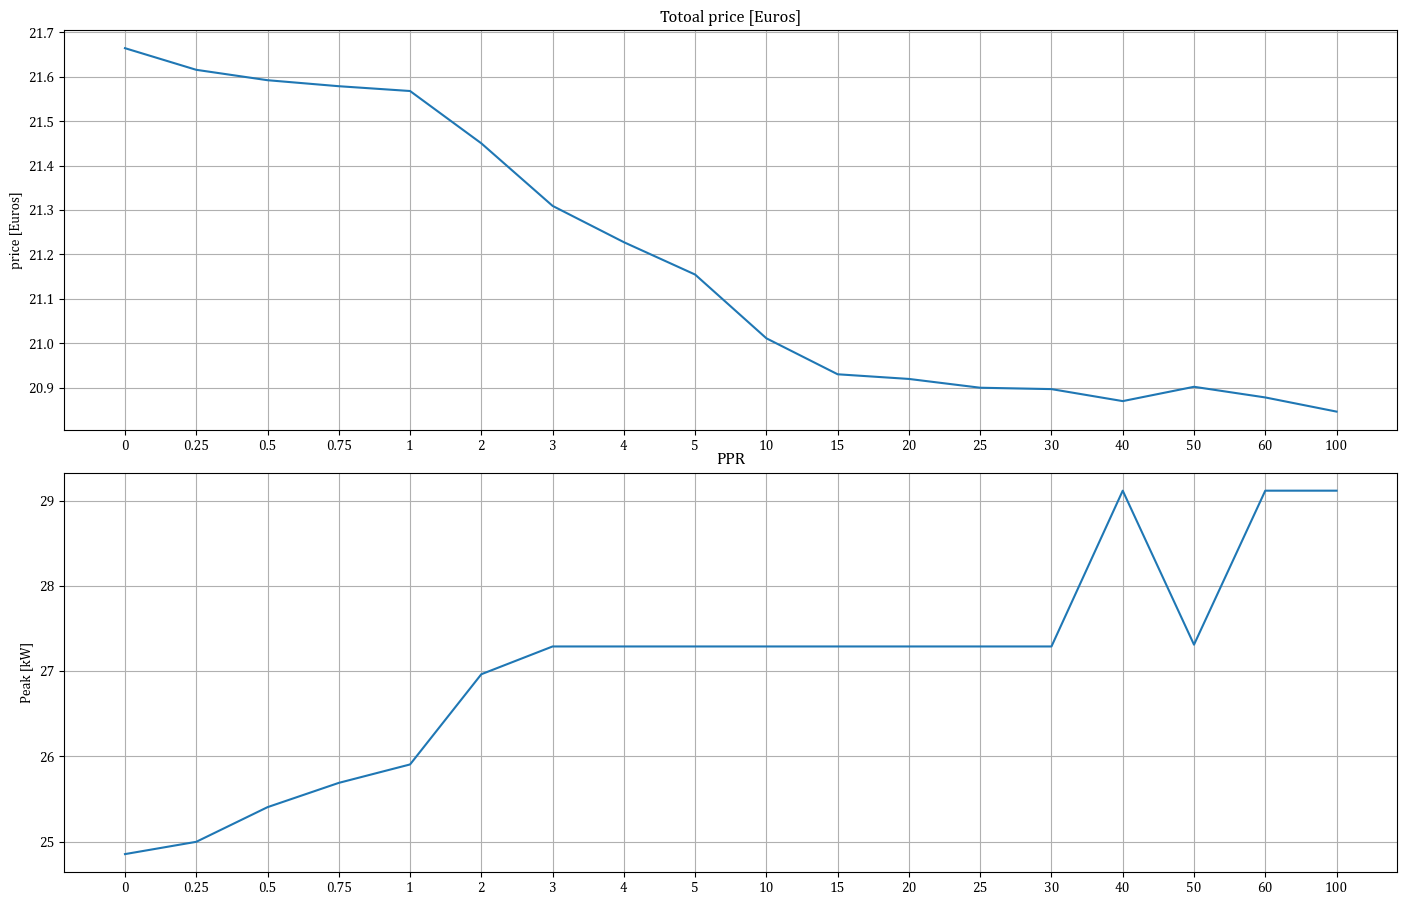

In [108]:
fig, axs = plt.subplots(2, 1, figsize=(14, 9), sharex=False)
iteration = [0, 0.25, 0.5, 0.75, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 60, 100]
xi = list(range(len(TotalPrice)))

plt.rcParams["font.family"] = "Cambria"
fig.tight_layout()
axs[0].set_title('Totoal price [Euros]')
axs[0].plot(xi,TotalPrice)
axs[0].grid()
axs[0].set_ylabel('price [Euros]')
plt.xticks(xi, iteration)

axs[1].set_title('PPR')
axs[1].plot(xi,PeakPower)
axs[1].grid()
axs[1].set_ylabel('Peak [kW]')
plt.setp(axs, xticks=xi, xticklabels=iteration)

Ipopt 3.11.1: max_iter=100000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     5103
Number of nonzeros in inequality constraint Jacobian.:     1122
Number of nonzeros in Lagrangian Hessian.............:     1437

Total number of variables............................:     2445
                     variables with only lower bounds:        0
                variables with lower and upper b

  83 -2.1157776e+005 1.74e+000 7.25e+000  -1.7 2.55e+001  -1.6 1.00e+000 3.65e-001f  1
  84 -2.1158475e+005 1.60e+000 9.16e+000  -1.7 3.65e+001  -2.1 1.00e+000 7.83e-002f  1
  85 -2.1161668e+005 7.46e-001 7.63e-001  -1.7 1.46e+001  -1.7 1.00e+000 1.00e+000f  1
  86 -2.1166419e+005 2.34e+000 2.04e+000  -1.7 3.54e+001  -2.1 1.00e+000 6.57e-001f  1
  87 -2.1166431e+005 2.28e+000 2.56e+000  -1.7 1.12e+001  -1.7 1.00e+000 2.78e-002h  1
  88 -2.1172749e+005 9.27e+000 5.43e-001  -1.7 4.35e+001  -2.2 1.00e+000 1.00e+000f  1
  89 -2.1174895e+005 1.06e+001 5.91e-001  -1.7 5.20e+002  -2.7 5.14e-002 4.60e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -2.1174900e+005 1.06e+001 5.89e-001  -1.7 6.12e+001  -2.3 9.23e-003 4.42e-003h  1
  91 -2.1184376e+005 2.25e+001 2.99e+000  -1.7 7.87e+001  -2.7 1.00e+000 8.03e-001f  1
  92 -2.1178932e+005 7.94e+000 7.53e-001  -1.7 2.81e+001  -2.3 8.77e-001 6.69e-001h  1
  93 -2.1178977e+005 7.74e+000 7.67e-001  -1.7 1.

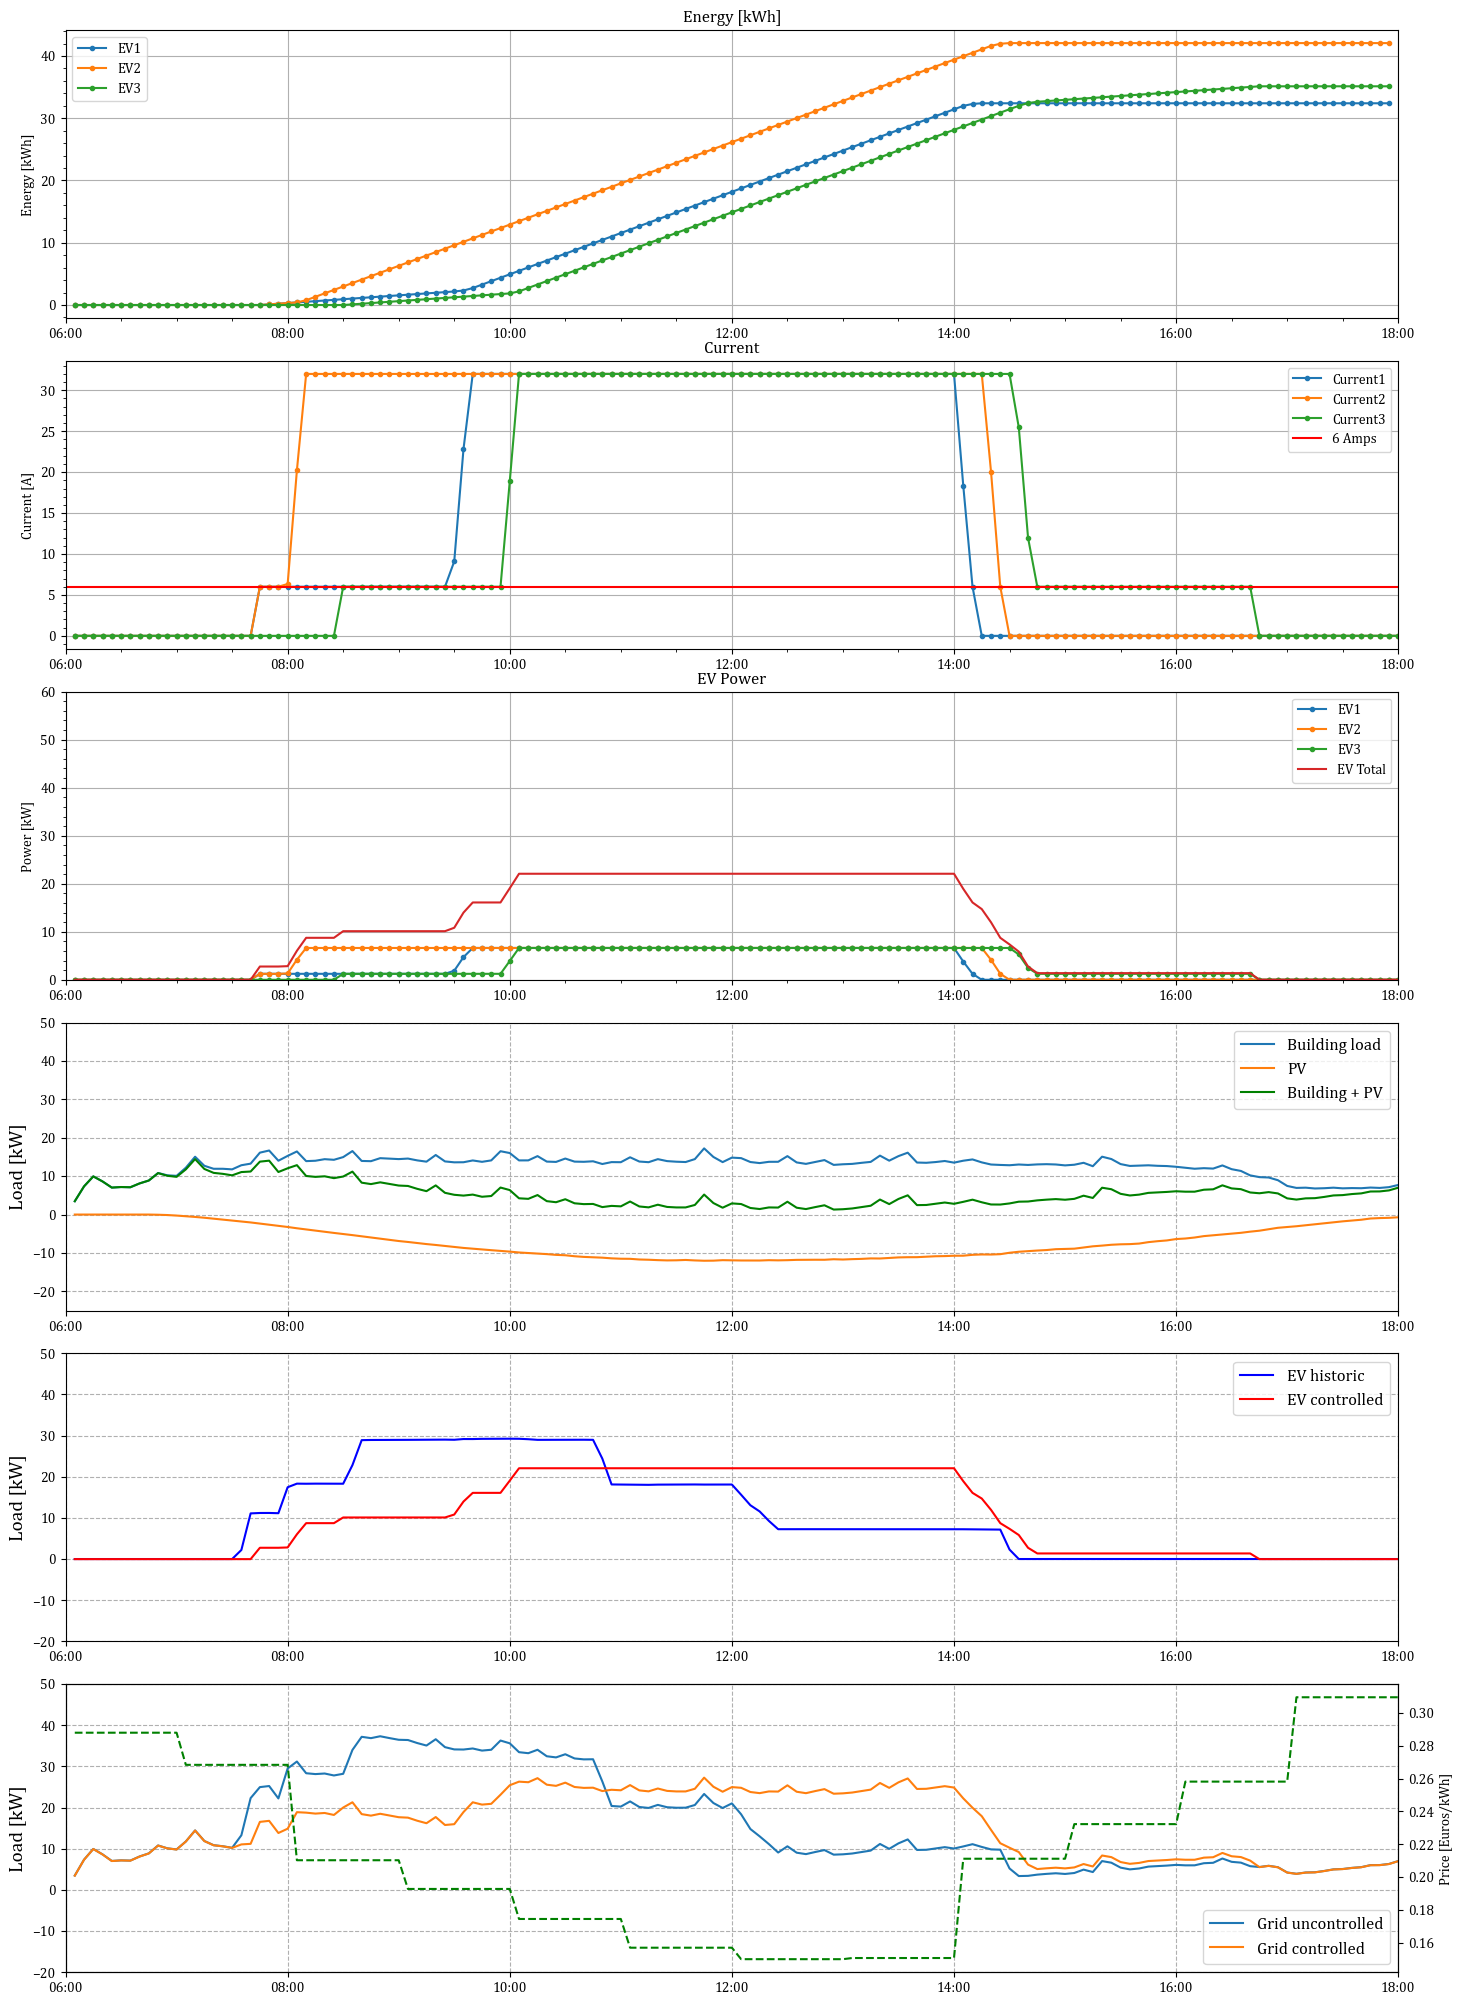

In [31]:
# Weight factor for the penalty function
weight = 30


mymodel= create_model(df_load, df_ev, weight, spot_data_5min)

# Done! now you have to solve the model!
solver = SolverFactory('ipopt') # This is ipopt, locally installed nonlinear solver
solver.options['max_iter']= 100000 # Number of iterations
results = solver.solve(mymodel, tee=True) # tee means to show the steps of the solver

# organizing results
for s in mymodel.S:
    pv = [mymodel.Ppv[k]() for k in mymodel.N]
    load = [mymodel.Pload[k]() for k in mymodel.N]
    grid = [mymodel.Pgrid[k]() for k in mymodel.N]
    grid_plus = [mymodel.Pgrid_plus[k]() for k in mymodel.N]
    grid_min = [mymodel.Pgrid_min[k]() for k in mymodel.N]
    price = [mymodel.price[k]() for k in mymodel.N]

E_EV = []
P_EV = []
Icharge = []
Ptot = []

for i in mymodel.V:
    E_EV.append([mymodel.Eev[k,i]() for k in mymodel.N]) 
    P_EV.append([mymodel.Pev[k,i]() for k in mymodel.N]) 
    Icharge.append([mymodel.Icharge[k,i]() for k in mymodel.N])

P_EVT = [mymodel.Pevtot[k]() for k in mymodel.N] 


result_df = pd.DataFrame()
for i in mymodel.V:
    result_df['EV' + str(i+1)] = pd.DataFrame(data=E_EV[i])
    result_df['PEV' + str(i+1)] = pd.DataFrame(data=P_EV[i])
    result_df['Current' + str(i+1)] = pd.DataFrame(data=Icharge[i])

result_df['PEVTot'] = pd.DataFrame(data=P_EVT)
result_df['PV'] = pd.DataFrame(data=pv)
result_df['Load'] = pd.DataFrame(data=load)
result_df['Grid'] = pd.DataFrame(data=grid)
result_df['Grid_plus'] = pd.DataFrame(data=grid_plus)
result_df['Grid_min'] = pd.DataFrame(data=grid_min)
result_df['price'] = pd.DataFrame(data=price)

result_df.index = pd.to_datetime(df_load.index)
pd.set_option('display.max_rows', 97)
#result_df.head(97)

fig, axs = plt.subplots(6, 1, figsize=(14, 20), sharex=False)
plt.rcParams["font.family"] = "Cambria"
fig.tight_layout()
axs[0].set_title('Energy [kWh]')
for i in mymodel.V:
    axs[0].plot(result_df['EV' + str(i+1)], label='EV' + str(i+1), marker=".")
axs[0].grid()
axs[0].set_ylabel('Energy [kWh]')
axs[0].legend()
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axs[0].minorticks_on()
axs[0].set_xlim(pd.Timestamp(fromDate), pd.Timestamp(toDate))

axs[1].set_title('Current')
for i in mymodel.V:
    axs[1].plot(result_df['Current' + str(i+1)], label='Current' + str(i+1), marker=".")
axs[1].grid()
axs[1].set_ylabel('Current [A]')
axs[1].axhline(y=6, color="red", label="6 Amps")
axs[1].legend()
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axs[1].minorticks_on()
axs[1].set_xlim(pd.Timestamp(fromDate), pd.Timestamp(toDate))

axs[2].set_title('EV Power')
for i in mymodel.V:
    axs[2].plot(result_df['PEV' + str(i+1)], label='EV' + str(i+1), marker=".")
axs[2].plot(result_df['PEVTot'], label="EV Total")
axs[2].grid()
axs[2].set_ylabel('Power [kW]')
axs[2].legend()
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axs[2].minorticks_on()
axs[2].set_xlim(pd.Timestamp(fromDate), pd.Timestamp(toDate))
axs[2].set_ylim([0,60])

axs[3].plot(df_loadspartially['Aggregated'], label='Building load')
axs[3].plot(df_pvpartially.iloc[:, 0], label="PV")
axs[3].plot(df_pvpartially.iloc[:, 0] + df_loadspartially['Aggregated'], label="Building + PV", color="green")
axs[3].set_xlim(pd.Timestamp(fromDate), pd.Timestamp(toDate))
axs[3].set_ylabel('Load [kW]', fontsize=14)
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axs[3].legend(loc='upper right', fontsize=12)
axs[3].set_ylim([-25, 50])
axs[3].grid(linestyle='--')

axs[4].plot(df_loadEVpartially['Aggregated'], label="EV historic", color="blue")
axs[4].plot(result_df['PEVTot'], label="EV controlled", color="red")
axs[4].set_xlim(pd.Timestamp(fromDate), pd.Timestamp(toDate))
axs[4].set_ylabel('Load [kW]', fontsize=14)
axs[4].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axs[4].legend(loc='upper right', fontsize=12)
axs[4].set_ylim([-20, 50])
axs[4].grid(linestyle='--')

axs[5].plot((df_pvpartially.iloc[:, 0] + df_loadspartially['Aggregated'] + df_loadEVpartially['Aggregated']), label="Grid uncontrolled")
axs[5].plot(result_df['Grid'], label="Grid controlled")
axs[5].set_xlim(pd.Timestamp(fromDate), pd.Timestamp(toDate))
axs[5].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axs[5].set_ylim([-20, 50])

axs[5].set_ylabel('Load [kW]', fontsize=14)
axs[5].grid(linestyle='--')
axs[5].legend(loc='lower right', fontsize=12)

ax5_1 = axs[5].twinx()
ax5_1.plot(result_df['price'], 'g--')
ax5_1.set_ylabel('Price [Euros/kWh]')


# KPI evaluation
print('Price = ', sum(P_EVT*result_df['price']/12), 'Euros')

df_grid = pd.DataFrame()
df_grid['Load'] = df_loadspartially['Aggregated'] + df_loadEVpartially['Aggregated']
df_grid['Grid'] = df_pvpartially.iloc[:, 0] + df_loadspartially['Aggregated'] + df_loadEVpartially['Aggregated']
PPR = df_grid['Grid'].max() - result_df['Grid'].max()
print('Power peak = ', PPR, 'kW')
